# BERT FOR QUESTION ANSWER TASK

In [2]:
# Import nesscessary libraries
import numpy as np
import pandas as pd
import torch
from transformers import BertForQuestionAnswering, AdamW
from torch.utils.data import DataLoader, Dataset
import json
import os
from transformers import AutoTokenizer, get_linear_schedule_with_warmup
import warnings
warnings.filterwarnings('ignore')


In [5]:
# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = BertForQuestionAnswering.from_pretrained("bert-base-multilingual-cased")

# Load tokenizer 
tokenizer = AutoTokenizer.from_pretrained("bert-base-multilingual-cased")


config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Some weights of BertForQuestionAnswering were not initialized from the model checkpoint at bert-base-multilingual-cased and are newly initialized: ['qa_outputs.bias', 'qa_outputs.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

Ý nghĩa warning notification: 

- Mô hình bert-base-uncased là một mô hình BERT gốc được huấn luyện cho các tác vụ chung chung. Tuy nhiên, khi sử dụng mô hình này cho tác vụ trả lời câu hỏi (Question Answering), một số lớp cuối của mô hình (`qa_outputs`) không có sẵn trong checkpoint và cần được thêm vào.

- Cho nên, các tham số này (`qa_outputs.bias`, `qa_outputs.weight`) cần được khởi tạo ngẫu nhiên.

Để giải quyết cảnh báo này, có thể thực hiện huấn luyện lại các tham số của mô hình cho tác vụ trả lời câu hỏi.

In [6]:
# Load data
with open('/kaggle/input/vietnamese-squad/dev-v2.0-translated.json', 'r', encoding='utf-8') as f:
    train_data = json.load(f)
    
with open('/kaggle/input/vietnamese-squad/train-v2.0-translated.json', 'r', encoding='utf-8') as f:
    dev_data = json.load(f)
    
# Format the data for SQuAD-like structure
def format_squad_data(data):
    formatted_data = []
    for context, question, answer in data:
        formatted_data.append({"context": context, "question": question, "answer": answer})
    return formatted_data

train_data = format_squad_data(train_data)
dev_data = format_squad_data(dev_data)

print("Sample data: \n", train_data[:2])

Sample data: 
 [{'context': 'Người Norman (Norman: Nourmands; French: Normands; Latin: Normanni) là những người trong thế kỷ 10 và 11 đã đặt tên cho Normandy, một khu vực ở Pháp. Họ là hậu duệ của những kẻ cướp biển và cướp biển Norse ("Norman" đến từ "Norseman") từ Đan Mạch, Iceland và Na Uy, dưới sự lãnh đạo của Rollo, đã đồng ý thề trung thành với Vua Charles III của Tây Francia. Qua nhiều thế hệ đồng hoá và trộn lẫn với dân số Frank và La Mã-Gaulish bản địa, con cháu của họ sẽ dần dần hợp nhất với các nền văn hoá dựa trên Carolingian của Tây Francia. Bản sắc văn hoá và dân tộc riêng biệt của người Norman xuất hiện ban đầu vào nửa đầu thế kỷ 10, và nó tiếp tục phát triển trong các thế kỷ tiếp theo.', 'question': 'Normandy nằm ở quốc gia nào?', 'answer': 'Pháp'}, {'context': 'Người Norman (Norman: Nourmands; French: Normands; Latin: Normanni) là những người trong thế kỷ 10 và 11 đã đặt tên cho Normandy, một khu vực ở Pháp. Họ là hậu duệ của những kẻ cướp biển và cướp biển Norse ("Nor

In [7]:
class QADataset(Dataset):
    def __init__(self, data, tokenizer, max_length=512):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        entry = self.data[idx]
        
        # Tokenize với chỉ phần context được cắt ngắn nếu quá dài
        inputs = self.tokenizer(
            entry['question'],
            entry['context'],
            max_length=self.max_length,
            truncation="only_second",  # Chỉ cắt ngắn context
            padding="max_length",
            return_tensors="pt",
            return_offsets_mapping=True  # Lấy offset để xác định vị trí câu trả lời
        )

        input_ids = inputs["input_ids"].squeeze()
        attention_mask = inputs["attention_mask"].squeeze()
        offsets = inputs["offset_mapping"].squeeze()

        # Tìm vị trí bắt đầu và kết thúc của câu trả lời trong văn bản gốc
        answer_start = entry['context'].find(entry['answer'])
        answer_end = answer_start + len(entry['answer'])

        # Khởi tạo vị trí bắt đầu và kết thúc mặc định nếu không tìm thấy
        start_positions, end_positions = 0, 0

        # Duyệt qua các token để tìm token chứa vị trí bắt đầu và kết thúc của câu trả lời
        for i, (start, end) in enumerate(offsets):
            # Nếu token này bao gồm vị trí bắt đầu của câu trả lời
            if start <= answer_start < end:
                start_positions = i
            # Nếu token này bao gồm vị trí kết thúc của câu trả lời
            if start < answer_end <= end:
                end_positions = i
                break

        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "start_positions": torch.tensor(start_positions),
            "end_positions": torch.tensor(end_positions),
        }


# Load tokenizer and create datasets
train_dataset = QADataset(train_data, tokenizer)
dev_dataset = QADataset(dev_data, tokenizer)

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
dev_loader = DataLoader(dev_dataset, batch_size=8)

for batch in train_loader:
    print("Input IDs:", batch['input_ids'])
    print("Attention Mask:", batch['attention_mask'])
    print("Start Positions:", batch['start_positions'])
    print("End Positions:", batch['end_positions'])
    break 


Input IDs: tensor([[  101, 29546, 13848,  ...,     0,     0,     0],
        [  101, 53125, 49309,  ...,     0,     0,     0],
        [  101, 61767, 10147,  ...,     0,     0,     0],
        ...,
        [  101, 20220, 29882,  ...,     0,     0,     0],
        [  101, 31701, 40352,  ...,     0,     0,     0],
        [  101, 21255, 11634,  ...,     0,     0,     0]])
Attention Mask: tensor([[1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]])
Start Positions: tensor([ 30,  13,  14,  10, 109,  18,  17,  12])
End Positions: tensor([  0,   0,   0,   0, 120,   0,   0,   0])


In [8]:
# Load the BERT model for QA and move it to the device (CPU/GPU)
model.to(device)
print(f"Successfully moved model to {device}!")


Successfully moved model to cuda!


In [17]:
# Hyperparametersv -----------------------------------------------------------------------------------------------------------
learning_rate = 3e-5     # Giá trị này thường nằm trong khoảng từ 1e-5 đến 5e-5 cho các mô hình BERT.                        |
batch_size    = 8        # Giá trị này nên được chọn dựa trên bộ nhớ GPU có sẵn và kích thước của dữ liệu.                   |
num_epochs    = 5        # Số lượng epoch nên được chọn dựa trên độ phức tạp của mô hình và kích thước của tập dữ liệu.      |
weight_decay  = 0.01     # Giá trị này thường nằm trong khoảng từ 0 đến 0.1, với giá trị phổ biến là 0.01                    | 
max_length    = 384      # Giá trị thường được chọn cho max_length là từ 384 đến 512.                                        |
doc_stride    = 128      # Giá trị thường chọn 128 tokens hoặc xuống 64 nếu thấy rằng mô missing nhiều thông tin quan trọng  |
warmup_steps_ratio = 0.1 # Tỷ lệ từ 0.1 đến 0.2 thường được khuyến nghị                                                      |

**Định nghĩa:**

- `learning_rate`:  Tốc độ học của mô hình. Tốc độ học quá cao có thể làm mô hình không hội tụ, trong khi tốc độ quá thấp có thể làm cho quá trình huấn luyện diễn ra chậm hơn.
- `batch_size`: Số lượng mẫu trong mỗi lô (batch) khi huấn luyện. Một batch_size lớn hơn có thể giúp tăng tốc quá trình huấn luyện nhưng yêu cầu nhiều bộ nhớ GPU hơn.
- `num_epochs`: Số lượng lần mô hình sẽ duyệt qua toàn bộ tập huấn luyện. Nếu số epoch quá thấp, mô hình có thể chưa học đủ; nếu quá cao, có thể xảy ra hiện tượng quá khớp (overfitting).
- `weight_decay`: Tham số giúp giảm thiểu hiện tượng quá khớp bằng cách thêm một hình phạt cho các trọng số lớn trong quá trình tối ưu hóa. Nó có thể điều chỉnh tốt độ chính xác mà không làm giảm khả năng học của mô hình.
- `max_length`: Độ dài tối đa cho đầu vào (câu hỏi + ngữ cảnh). Giới hạn này giúp kiểm soát việc cắt bớt (truncation) dữ liệu quá dài.
- `doc_stride`: Khoảng cách trượt giữa các đoạn ngữ cảnh, cho phép mô hình xử lý ngữ cảnh dài hơn mà không bỏ lỡ thông tin quan trọng.
- `warmup_steps_ratio`: Tỉ lệ bước khởi động để làm mượt tốc độ học trong giai đoạn đầu, tránh các biến động lớn trong quá trình huấn luyện.

In [13]:
from tqdm import tqdm

# Define optimizer
optimizer = AdamW(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
total_steps = len(train_loader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=int(total_steps * warmup_steps_ratio), num_training_steps=total_steps)

# Training loop
def train(model, dataloader, optimizer, scheduler):
    model.train()
    total_loss = 0
    for batch in tqdm(dataloader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)

        # Compute loss
        outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
        loss = outputs.loss
        total_loss += loss.item()

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    avg_loss = total_loss / len(dataloader)
    return avg_loss

for epoch in range(num_epochs):
    avg_loss = train(model, train_loader, optimizer, scheduler)
    print(f"Epoch {epoch+1}/{num_epochs} completed. Average Loss: {avg_loss}")

Training: 100%|██████████| 1485/1485 [20:55<00:00,  1.18it/s]


Epoch 1/5 completed. Average Loss: 2.4000763411875123


Training: 100%|██████████| 1485/1485 [20:58<00:00,  1.18it/s]


Epoch 2/5 completed. Average Loss: 1.7700845376208976


Training: 100%|██████████| 1485/1485 [20:58<00:00,  1.18it/s]


Epoch 3/5 completed. Average Loss: 1.4491999314690278


Training: 100%|██████████| 1485/1485 [20:58<00:00,  1.18it/s]


Epoch 4/5 completed. Average Loss: 1.1165601623680455


Training: 100%|██████████| 1485/1485 [20:58<00:00,  1.18it/s]

Epoch 5/5 completed. Average Loss: 0.8436695987270888


Recap output training loop:

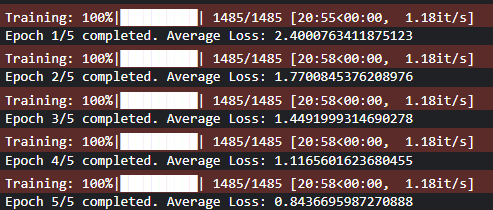

In [18]:
from sklearn.metrics import accuracy_score

def evaluate(model, dataloader):
    model.eval()
    exact_match = 0
    total = 0
    
    for batch in tqdm(dataloader, desc="Evaluating"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        start_positions = batch['start_positions'].to(device)
        end_positions = batch['end_positions'].to(device)
        
        with torch.no_grad():
            outputs = model(input_ids, attention_mask=attention_mask)
            start_logits = outputs.start_logits
            end_logits = outputs.end_logits

        # Chọn vị trí bắt đầu và kết thúc với xác suất cao nhất
        start_preds = torch.argmax(start_logits, dim=1)
        end_preds = torch.argmax(end_logits, dim=1)

        # Kiểm tra tính chính xác
        for i in range(len(start_positions)):
            total += 1
            if start_preds[i] == start_positions[i] and end_preds[i] == end_positions[i]:
                exact_match += 1
    
    accuracy = exact_match / total if total > 0 else 0
    return accuracy

accuracy = evaluate(model, dev_loader)

Evaluating: 100%|██████████| 16290/16290 [1:15:33<00:00,  3.59it/s]


In [19]:
print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.2905


> Cần tìm 1 metric đánh giá khác!

In [20]:
# Save the model and tokenizer
model.save_pretrained("/kaggle/working/fine_tuned_bert_qa")
tokenizer.save_pretrained("/kaggle/working/tokenizer_fine_tuned_bert_qa")

('./tokenizer_fine_tuned_bert_qa/tokenizer_config.json',
 './tokenizer_fine_tuned_bert_qa/special_tokens_map.json',
 './tokenizer_fine_tuned_bert_qa/vocab.txt',
 './tokenizer_fine_tuned_bert_qa/added_tokens.json',
 './tokenizer_fine_tuned_bert_qa/tokenizer.json')

In [1]:
def inference(model, question, context, tokenizer, max_length=384, doc_stride=128):
    model.eval()
    
    # Tokenize câu hỏi và ngữ cảnh
    inputs = tokenizer(
        question,
        context,
        max_length=max_length,
        truncation="only_second",
        padding="max_length",
        stride=doc_stride,
        return_tensors="pt"
    ).to(device)

    with torch.no_grad():
        outputs = model(**inputs)
        start_logits = outputs.start_logits
        end_logits = outputs.end_logits

    # Tính toán vị trí bắt đầu và kết thúc có xác suất cao nhất
    start_index = torch.argmax(start_logits)
    end_index = torch.argmax(end_logits)

    # Chuyển đổi các token đã mã hóa thành chuỗi văn bản
    all_tokens = inputs['input_ids'].squeeze().tolist()
    answer_tokens = all_tokens[start_index:end_index + 1]
    answer = tokenizer.decode(answer_tokens, skip_special_tokens=True)

    print(f"Question: {question}")
    print(f"Answer: {answer}")
    return answer

# Q & A:
question = "Nước biển ở đâu có nhạt nhất?"
context = "Khi sự pha trộn với nước ngọt đổ ra từ các con sông hay gần các sông băng đang tan chảy thì nước biển nhạt hơn một cách đáng kể. Nước biển nhạt nhất có tại vịnh Phần Lan, một phần của biển Baltic."
answer = inference(model, question, context, tokenizer)

Question: Nước biển ở đâu có nhạt nhất?
Answer: vịnh Phần Lan


In [3]:
# Q & A:
question = "TMA hiện tại có tổng cộng bao nhiêu văn phòng?"
context = "TMA Solutions được thành lập năm 1997, TMA tự hào là công ty phần mềm hàng đầu Việt Nam. Với 27 năm phát triển vững mạnh, TMA đã xây dựng được một đội ngũ với hơn 4,000 kỹ sư tài năng, nhiệt huyết luôn nhận được sự đánh giá cao từ phía khách hàng, cùng chung tay xây dựng hình ảnh TMA - đối tác tin cậy trên bản đồ công nghệ thông tin toàn cầu. TMA hiện có 6 văn phòng tại Việt Nam (5 tại TP Hồ Chí Minh và 1 ở TP Quy Nhơn) cùng với 6 văn phòng ở nước ngoài (Mỹ, Canada, Đức, Nhật, Úc, Singapore)."
answer = inference(model, question, context, tokenizer)

Question: TMA là gì?
Answer: TMA là công ty phần mềm hàng đầu Việt Nam


---------